This notebook first introduces dimensionality to the ExpCGM model, then computes some of the observable atmospheric characteristics that can be output by the ExpCGM model. We calculate the Compton-y parameter, surface mass density, and line intensity for an ExpCGM atmosphere using projected profiles.

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.interpolate import interp1d
from astropy.io import fits


eps = 10**(-4)

# ---------- constants ----------
G      = 6.67430e-8          # cm^3 g^-1 s^-2
A_NFW  = 4.625
f_b    = 0.16
sigma_T= 6.6524587158e-25    # cm^2
m_e    = 9.1093837015e-28    # g
m_p    = 1.67262192369e-24   # g
c      = 2.99792458e10       # cm s^-1
mu     = 0.6
mu_e   = 1.14
k_B    = 1.380649e-16        # erg K^-1
h      = 6.62607015e-27      # erg s
k_B_keV_per_K = 8.617333262e-8  # keV K^-1
X_H = 0.76
mu_H = 1.0 / X_H
cm_per_kpc = 3.085677581e21   # 1 kpc to cm
cm_per_pc  = 3.085677581e18   # 1 pc to cm
Msun       = 1.98847e33       # g


# 1. Hubble Parameter and Critical Density

We calculate the Hubble parameter $H(z)$ at a specified redshift, from the scale factor $\displaystyle a = \frac{1}{1+z}$:
\begin{align*}
H &= H_0 \sqrt{\Omega_R \cdot a^{-4} + \Omega_M \cdot a^{-3} + \Omega_K \cdot a^{-2} + \Omega_\Lambda}\\[3pt]
&\approx H_0 \sqrt{10^{-3} \cdot a^{-4} + 0.3 \cdot a^{-3} + 0 \cdot a^{-2} + 0.7}
\end{align*}
Then we compute the critical density:
$$
\rho_{\rm cr}(z) = \frac{3H(z)^2}{8\pi G}
$$


In [2]:
# calculating the hubble parameter

z = 1

hubble_factor = 1/(1+z)

H_0 = 2.27e-18

H = H_0 * np.sqrt(1e-3 * hubble_factor**(-4) + 0.3 * hubble_factor**(-3) + 0 * hubble_factor**(-2) + 0.7)

print('Hubble parameter:', H)

# halo mass
M_halo = 4e12 * Msun #g

# the mass of the CGM is M_halo times the baryon fraction
M_CGM = f_b * M_halo

# critical density
rho_cr = 3 * H**2 / (8 * np.pi * G)

Hubble parameter: 4.007048340112706e-18


# 2. Halo Properties

For the boundary of the CGM, we use the common definition of $r_{200}$, the radius at which the density is $200$ times the critical density,
$$
\rho_{\rm cr} = \frac{3H^2(z)}{8\pi G}
$$
Then, with $\Delta = 200$, we calculate $r_\Delta$ as:
$$
r_\Delta = \left(\frac{3 M_\Delta}{4 \pi \Delta  \rho_{\rm cr}}\right)^{1/3}
$$

In [3]:
Delta = 200

# setting r_halo to r_200
r_halo = ((3 * M_halo) / (4 * np.pi * Delta * rho_cr))**(1/3)

# circular velocity at r_halo
vc2_halo = G * M_halo / r_halo

print('The halo radius is', r_halo / cm_per_kpc, 'kpc')
print('The halo circular velocity is', np.sqrt(vc2_halo)/1e5, 'km/s')

The halo radius is 224.0928430161168 kpc
The halo circular velocity is 277.07868209989573 km/s


In all NFW profiles, the shape of the rotation curve is the same. We use a template NFW curve to calculate the ratio between $v_{\rm halo}$ and $v_\varphi$, the maximum velocity. For the scale radius $r_0$, we can approximate $r_{\rm halo} \approx 10 \, r_0$ here.

In [4]:
# we use the an NFW profile to calculate the velocity ratio which remains constant, then use it to find v_phi^2
def vc2_NFW_template(x):
    return A_NFW * (np.log(1+x) / x - 1 / (1+x))

ratio_point = 10

r_0 = r_halo / ratio_point

halo_vc2_ratio = vc2_NFW_template(ratio_point)

vphi2 = vc2_halo / halo_vc2_ratio

print('The maximum circular velocity is', np.sqrt(vphi2)/1e5, 'km/s')

The maximum circular velocity is 333.90923317635054 km/s


We use the ExpCGM model code explained in Notebook 1 up to the point of finding $I(x)$, which will be useful for the density and pressure profiles.

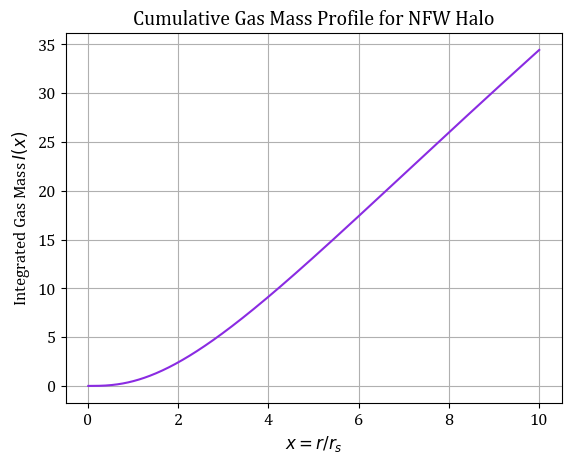

In [5]:
# Using the model described in the first notebook

x_values = np.linspace(0.01, 10, 500)

rmax = 2.16258

def alpha(x):
    return (3.4*x)/(rmax + x)

def integrandf_P(t):
    return alpha(t) / t

def f_P(x):        
    resultf_P, _ = integrate.quad(integrandf_P, 1+eps, x, limit=500)
    return np.exp(-resultf_P)

def vc2_gal(x):
    return 4 * 0.1 * x / (x + 0.1)**2

def v2_NFW_pre(x):
    return A_NFW * vphi2 * (np.log(1+x) / x - 1 / (1+x))

def v2_NFW(x):
    return v2_NFW_pre(x) + vc2_gal(x)

def integrandI(t):
    return vphi2 * alpha(t) * f_P(t) * t**2 / (v2_NFW(t))

def I(x):        
    resultI, _ = integrate.quad(integrandI, eps, x, limit=50)
    return resultI

I_vec = np.vectorize(I)
y_I = I_vec(x_values)

cfont = {'fontname':'cambria'}
plt.rcParams['font.family'] = 'cambria' 
plt.rcParams['font.size'] = 12  
plt.plot(x_values, y_I, color='blueviolet')
plt.title('Cumulative Gas Mass Profile for NFW Halo', **cfont)
plt.xlabel('$x = r/r_{s}$',  **cfont)
plt.ylabel('Integrated Gas Mass $I(x)$',  **cfont)
plt.grid(True)

The density $\rho$ and pressure $P$ are dependent on the pressure normalization $P_0$, which is given by:
$$
P_0 = \frac{M_{\rm CGM}v_\varphi^2}{4\pi r_0^3}\frac{1}{I(r_{\rm CGM}/r_0)}
$$
Then, by the definition of the dimensionless shape pressure profile $f_P$, the pressure profile is:
$$
P(r) = P_0 f_P(r)
$$
And the gas density profile becomes:
$$
\rho(r) = P_0 \,\frac{\alpha(r)f_P(r)}{v_c^2(r)}
$$

In [6]:
# pressure normalization
P_0 = M_CGM * vphi2 / (4*np.pi * r_0**3 * I(r_halo/r_0))

print('P_0:', P_0)

# pressure profile
def P(r):
    return P_0 * f_P(r/r_0)

# density profile
def rho(r):
    return P_0 * alpha(r/r_0) * f_P(r/r_0) / v2_NFW(r/r_0)

P_0: 9.916210570224916e-12


# 3. Surface Mass Density
Now that we have a model with physical quantities instead of dimensionless ones, we can start plotting observable properties of the atmosphere. The rest of this notebook provides examples of how we can derive observational predictions from the ExpCGM model.

In this part, we calculate the surface mass density profile along a projected radius $\Sigma_{\rm CGM}(r_{\perp})$ by performing the line-of-sight integral
$$
\Sigma(r_{\perp})
= \int_{-\infty}^{\infty} \rho(r)\,dr_{\parallel}
$$
Using $r_{\parallel} = \pm (r^2-r_{\perp}^2)^{1/2}$ and assuming the density is negligibly small after $r_{\rm halo}$,
$$
\Sigma(r_{\perp})
= 2 \int_{0}^{r_{\rm halo}} \rho\!\bigl(\sqrt{r_{\perp}^{2} + r_{\parallel}^{2}}\bigr)\,dr_{\parallel}
$$
We evaluate this integral for a logarithmically spaced grid of $r_{\perp}$ values, then plot on log–log axes.

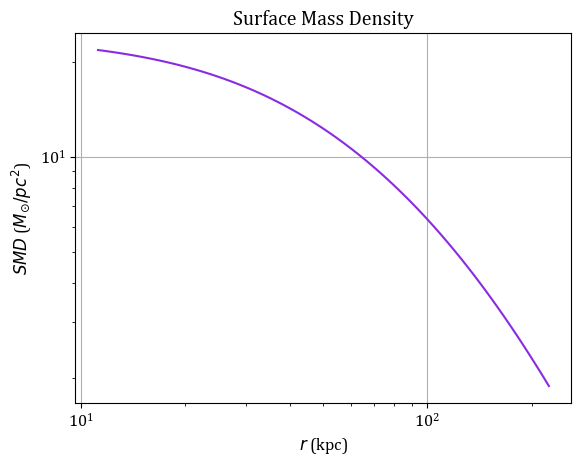

In [7]:
# integrating density along lines of sight gives the surface mass density
def SMD(r_perp):
    def integrand(r_parallel):
        r = np.sqrt(r_perp**2 + r_parallel**2)
        return rho(r) 

    result, _ = integrate.quad(integrand, 0, r_halo, limit=500)
    
    return 2 * result

r_min = 5e-2 * r_halo
r_perp_values = np.logspace(np.log10(r_min), np.log10(r_halo), 100)
SMD_1_values = np.vectorize(SMD)(r_perp_values)

# unit conversions
r_perp_values_kpc = r_perp_values / cm_per_kpc
SMD_1_values_Msunpc2 = SMD_1_values / (Msun/cm_per_pc**2)

cfont = {'fontname':'cambria'}
plt.rcParams['font.family'] = 'cambria' 
plt.rcParams['font.size'] = 12  
plt.plot(r_perp_values_kpc, SMD_1_values_Msunpc2, color='blueviolet')
plt.xlabel(r'$r$ (kpc)')
plt.ylabel(r'$SMD$ ($M_{\odot} / pc^2$)')
plt.title('Surface Mass Density')
plt.xscale('log')
plt.yscale('log')
plt.grid()

# 4. Compton Parameter

The Compton parameter is proportional to the thermal Sunyaev-Zeldovich effect, and can be calculated as a function of $r_{\perp}$ by evaluating the line‐of‐sight integral
$$
y = \int_{-\infty}^{\infty} \left(\frac{kT}{m_ec^2}\right)n_e \sigma_T\,dr_{\parallel}
$$
With a spherical ExpCGM atmosphere, this is equivalent to
$$
y(r_{\perp})
= 2P_{0}\,\frac{\mu\,\sigma_{T}}{\mu_{e}\,m_{e}\,c^{2}}
  \int_{0}^{r_{\rm halo}}
  f_{P}(r\;/\;r_{0})
  \,d r_{\parallel}
$$
where the prefactor $\frac{2P_{0}\mu\sigma_{T}}{\mu_{e}m_{e}c^{2}}$ incorporates the pressure normalization and physical constants.

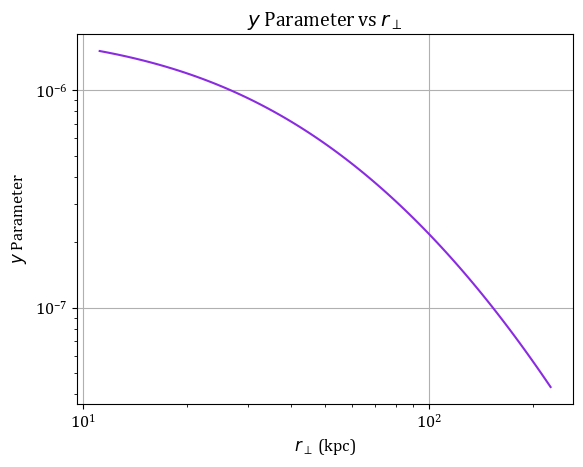

In [8]:
# integrating along a line of sight with the same method gives the Compton y parameter
def y_parameter(r_perp):
    def integrand(r_parallel):
        r = np.sqrt(r_perp**2 + r_parallel**2)
        return f_P(r/r_0)
    
    integral, _ = integrate.quad(integrand, 0, r_halo, limit=500)
    coeff = (2 * P_0 * mu * sigma_T) / (mu_e * m_e * c**2)
    return coeff * integral

y_values = np.vectorize(y_parameter)(r_perp_values)

cfont = {'fontname':'cambria'}
plt.rcParams['font.family'] = 'cambria' 
plt.rcParams['font.size'] = 12  
plt.plot(r_perp_values_kpc, y_values, color='blueviolet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_\\perp$ (kpc)')
plt.ylabel('$y$ Parameter')
plt.title('$y$ Parameter vs $r_\\perp$')
plt.grid()
plt.show()


# 5. Emission

We can use the ExpCGM model along with a dataset for temperature-dependent emissivities $\epsilon_\mathrm{line}(T)$ to calculate the line intensity for a specific line, given by the line-of-sight integral
$$
I_\mathrm{line}(r_\perp) = \int_{-\infty}^\infty n_e n_H \epsilon_\mathrm{line}(T) dr_\parallel
$$

First, we need functions for $n_e(r)$, $n_H(r)$, and $T(r)$. We calculate $T(r)$ using the gravitational temperature profile $T_\varphi(r) = \mu m_p v_c^2(r)/2k_B$ :
$$
T(r) = \frac{2T_\varphi(r)}{\alpha(r)}
$$

In [9]:
# electron and H number densities
def n_e(r):
    return rho(r) / (mu_e * m_p)

def n_H(r):
    return rho(r) / (mu_H * m_p)

# Gravitational Tphi
def T_phi(r):
    return mu * m_p * v2_NFW(r/r_0) / (2 * k_B)

# Temperature profile
def T(r):
    return 2 * T_phi(r) / alpha(r/r_0)

To convert emissivity per ion into emissivity per hydrogen atom, we use a Solar-abundance table in the standard dex format
$$
A(Z) = \log_{10}(n_Z/n_H) + 12
$$
For this notebook we are using the O VIII Ly-$\alpha$ line, but this can be easily changed.

In [10]:
SOLAR_ABUND_DEX = {
    1: 12.00,  # H
    2: 10.98,  # He
    6:  8.50,  # C
    7:  7.86,  # N
    8:  8.76,  # O
    10: 8.02,  # Ne
    12: 7.60,  # Mg
    14: 7.51,  # Si
    16: 7.16,  # S
    18: 6.40,  # Ar
    20: 6.34,  # Ca
    26: 7.52,  # Fe
}

SOLAR_ABUND = {Z: 10**(A - 12.0) for Z, A in SOLAR_ABUND_DEX.items()}

ATOMIC_SYMBOL = {1:'H', 2:'He', 6:'C', 7:'N', 8:'O', 10:'Ne', 12:'Mg',
    14:'Si', 16:'S', 18:'Ar', 20:'Ca', 26:'Fe'}


We use the AtomDB dataset to get emissivity values $\epsilon(T)$ as a function of plasma temperature. The notebook reads the APEC line FITS file and extracts:
* The temperature grid (in keV)
* The emissivity of the specific line of interest (selected by wavelength, element, and ionization state)

We specify a target line by the element, ion, wavelength, and wavelength tolerance. The function below finds the line and returns the temperature-dependent emissivity list for the line.

In [11]:
# Load line emissivity grid from AtomDB

def load_line_emissivity_from_apec(fits_path, target_lambda_A, target_element,
                                  target_ion, match_tol_A=0.01):

    hdul = fits.open(fits_path)
    params = hdul['PARAMETERS'].data
    kT_list, eps_list = [], []
    kT_keV_rows = params['kT']

    # Loop over all temperature bins in the file
    for i, kT_val in enumerate(kT_keV_rows):
        tb = hdul[2 + i].data
        lam = np.asarray(tb['Lambda']).astype(float)
        eps = np.asarray(tb['Epsilon']).astype(float)

        # matching wavelength within tolerance
        mask_lam = np.isfinite(lam) & (np.abs(lam - target_lambda_A) <= match_tol_A)
        mask_lam = mask_lam.astype(bool)

        # matching target element and ion
        elem = np.asarray(tb['Element']).astype(int)
        ion  = np.asarray(tb['Ion']).astype(int)

        mask_elem = (elem == target_element)
        mask_ion  = (ion  == target_ion)

        match = mask_lam & mask_elem & mask_ion

        # if the line exists in this temperature slice, extract emissivity
        if np.any(match):
            idx = np.where(match)[0][0]
            kT_list.append(kT_val)
            eps_list.append(eps[idx])
        else:
            kT_list.append(kT_val)
            eps_list.append(0.0)

    hdul.close()

    kT_arr = np.array(kT_list)
    eps_arr = np.array(eps_list)
    srt = np.argsort(kT_arr) # sort temperature in ascending order
    return kT_arr[srt], eps_arr[srt]


We now need to go from a discrete temperature grid to a continuous function for $\epsilon(T)$.

The function `make_epsilon_line_function` constructs a continuous, temperature-dependent emissivity function for the chosen emission line. In particular, it:
* Creates a continuous function $\epsilon(T)$, using linear interpolation. 
* Converts the emissivity from photon units that AtomDB provides, to energy units using $E = hc/\lambda$.
* Converts the temperature grid from units of $k_BT$ (keV) to physical temperature $T$ (K).
* Raises an error if there is no line match (the grid is all zeros).

In [12]:
# Build emissivity(T) function

def make_epsilon_line_function(fits_path, target_lambda_A, target_element, target_ion,
                               match_tol_A=0.01):
    kT_keV, eps_ph = load_line_emissivity_from_apec(
        fits_path, target_lambda_A, target_element, target_ion, match_tol_A)

    if np.all(eps_ph == 0):
        raise ValueError("Line not found. Check wavelength/element/ion.")

    T_grid = kT_keV / k_B_keV_per_K
    lam_cm = target_lambda_A * 1e-8
    E_photon = h * c / lam_cm

    eps_floor = np.maximum(eps_ph, 1e-40)
    interp_fn = interp1d(np.log(T_grid), np.log(eps_floor), kind='linear',
                            bounds_error=False, fill_value=-np.inf)
    def eps_ph_of_T(T):
        T_arr = np.asarray(T)
        val = np.exp(interp_fn(np.log(T_arr)))

        if np.isscalar(T):
            return val if np.isfinite(val) else 0.0
        else:
            val[~np.isfinite(val)] = 0.0
            return val

    def epsilon_line(T):
        eps_ph_val = eps_ph_of_T(T)
        eps_energy = eps_ph_val * E_photon / (4*np.pi)
        return eps_energy  # erg cm^3 s^-1 sr^-1

    return epsilon_line

We now specify the line using `target_lambda` ($\AA$), `target_Z`, and `target_ion`. We also specify metallicity which is then used to compute abundance.

The emissivity values in AtomDB take into account the ion fraction $n_{O^{8+}}/n_O$. We only have to multiply the output by the abundance, e.g. $n_O/n_H$.

We then compute the line of sight integral which calls for the `epsilon_line_fn` function inside the integrand, then vectorize and plot.

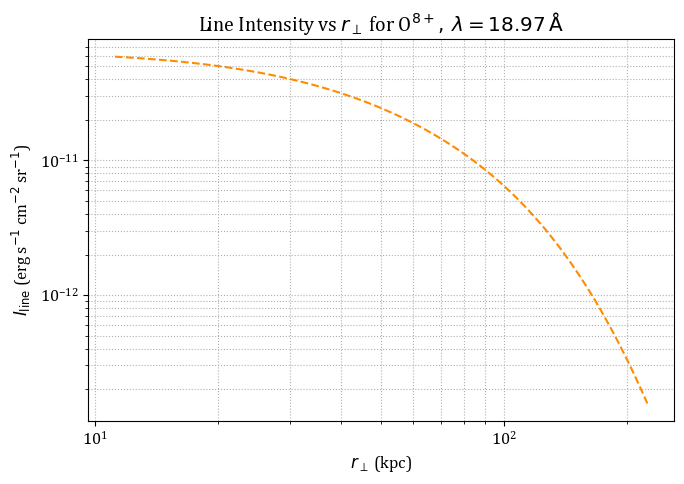

In [13]:
# Create epsilon_line function for chosen line
fits_path = "apec_line.fits"
target_lambda = 18.97
target_Z = 8
target_ion = 8
metallicity = 0.3       # Z/Z_solar


# Atomic abundance
def abundance_over_H(Z_number):
    return metallicity * SOLAR_ABUND.get(Z_number, 0.0)


epsilon_line_fn = make_epsilon_line_function(
    fits_path, target_lambda_A=target_lambda, target_element=target_Z,
    target_ion=target_ion, match_tol_A=0.02
)


# Line of sight intensity calculation
def I_line(r_perp, n_e, n_H, T, epsilon_line_fn):
    abundance = abundance_over_H(target_Z)

    def integrand(r_par):
        r = np.sqrt(r_perp**2 + r_par**2)
        ne = n_e(r)
        nH = n_H(r)
        Tloc = T(r)
        eps = epsilon_line_fn(Tloc)  # erg cm^3 s^-1 sr^-1
        return abundance * eps * ne * nH  # erg cm^-3 s^-1 sr^-1

    val, _ = integrate.quad(integrand, 0, r_halo, limit=200)
    return 2 * val  # erg s^-1 cm^-2 sr^-1


# Vectorization for plotting
def I_line_profile(r_perp_values):
    vec_fn = np.vectorize(lambda rp: I_line(
        rp, n_e, n_H, T, epsilon_line_fn))
    return vec_fn(r_perp_values)


# Plotting
# r_perp_values already defined
I_vals = I_line_profile(r_perp_values)

plt.figure(figsize=(7,5))
plt.plot(r_perp_values_kpc, I_vals, '--', color='darkorange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r_\perp$ (kpc)')
plt.ylabel(r'$I_\mathrm{line}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')
plt.title(rf'Line Intensity vs $r_\perp$ for {ATOMIC_SYMBOL.get(target_Z, f"Z{target_Z}")}$^{{{target_ion}+}}, \,\lambda = {target_lambda:.2f}\,\mathrm{{\AA}}$')
plt.grid(which='both', linestyle=':')
plt.tight_layout()
plt.show()